In [23]:
!pwd

/Users/neku5162/Desktop/sir_inversions/2_line_run


# Writing a neural network to see if the computer can identify tau vs from spectra

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, UnivariateSpline
import time
from astropy.io import fits

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
def readsim(file):
    raw = np.loadtxt(file)
    return np.transpose(raw.reshape((64,252,252)))

In [6]:
sim_z = np.loadtxt('/Users/neku5162/Desktop/time_series/z_100.csv')

short_z = sim_z[4:40] # cut the atmosphere to the values where the line is sensitive

sim_tau = np.log10(readsim('/Users/neku5162/Desktop/time_series/tau_100.csv')[:,:,1:])
sim_tau = np.append(np.zeros((252,252,1))-6.0,sim_tau,axis=2) ## append log tau = -6 at the start

raw_spectra = np.transpose(np.loadtxt('spectrum.csv').reshape((257,252,252)))

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
from keras.models import load_model

Using Theano backend.


In [8]:
n_batch = 128

In [9]:
model = Sequential()
model.add(Dense(n_batch, activation='relu')) # input dim is number of spectra...

model.add(Dense(64, activation='linear')) # input dim is number of spectra...
model.compile(optimizer='adam',
              loss='mse')

spectra_train = raw_spectra[:100,:100,:].reshape((10000,257))
tau_train = sim_tau[:100,:100,:].reshape((10000,64))

model.fit(spectra_train, tau_train, epochs=10, batch_size=n_batch)
print("finished training")
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
print("saved model")


Epoch 1/10
10000/10000 [==============================] - 0s 10us/step - loss: 5.6726
Epoch 2/10
10000/10000 [==============================] - 0s 11us/step - loss: 2.6223
Epoch 3/10
10000/10000 [==============================] - 0s 10us/step - loss: 0.5591
Epoch 4/10
10000/10000 [==============================] - 0s 10us/step - loss: 0.1993
Epoch 5/10
10000/10000 [==============================] - 0s 11us/step - loss: 0.1512
Epoch 6/10
10000/10000 [==============================] - 0s 9us/step - loss: 0.1364
Epoch 7/10
10000/10000 [==============================] - 0s 13us/step - loss: 0.1309
Epoch 8/10
10000/10000 [==============================] - 0s 20us/step - loss: 0.1291
Epoch 9/10
10000/10000 [==============================] - 0s 20us/step - loss: 0.1287
Epoch 10/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.1285
finished training
saved model


In [10]:
raw_spectra_list = raw_spectra.reshape((252*252,257))
raw_tau_list = sim_tau.reshape((252*252,64))

# Start making some maps with neural networks. 

In [11]:
sim_temp = readsim('/Users/neku5162/Desktop/time_series/t_100.csv')
tau_sir = np.loadtxt('pixels/0_0/guess.mod',skiprows=1)[:,0]
sim_temp_tau = np.loadtxt('sim_temp_tau.csv').reshape((252,252,len(tau_sir)))

In [12]:
temp_inversions = np.loadtxt('myfile.dat')
t_sir = np.transpose(temp_inversions.reshape(252,252,64),axes=[1,0,2])

In [14]:

def get_tau(i,j):
    return model.predict(np.array([raw_spectra[i,j,:]]))[0]

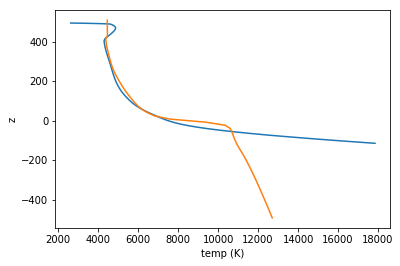

In [15]:
i = np.random.randint(252)
j = np.random.randint(252)
zoftau = interp1d(get_tau(i,j),sim_z,kind='linear')
plt.plot(t_sir[i,j,:],zoftau(tau_sir))
plt.plot(sim_temp[i,j,:],sim_z)
plt.ylabel('z')
plt.xlabel('temp (K)')

sir_z_temp = np.zeros((252,252,64))
for i in np.arange(252):
    for j in np.arange(252):
        #create interpolaing function for each pixel
        z_of_tau = interp1d(get_tau(i,j),sim_z,kind='linear',fill_value='extrapolate')

        t_of_z = interp1d(z_of_tau(tau_sir),t_sir[i,j,:],kind='linear',fill_value='extrapolate')
        
        sir_z_temp[i,j] = t_of_z(sim_z)

        

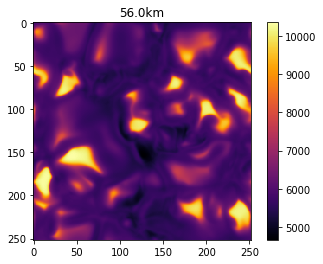

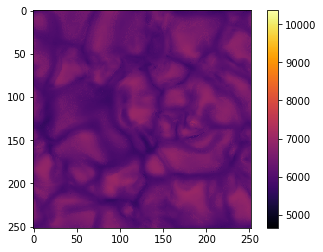

0.28025285990636495


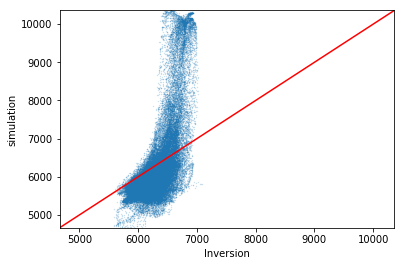

(0, 1)

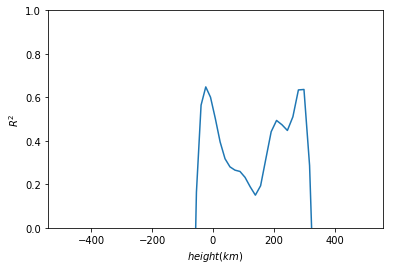

In [22]:
from sklearn.metrics import r2_score

index = 25
plt.imshow(sim_temp[:,:,index],cmap='inferno')
plt.title(str(round(sim_z[index])) + 'km')
cup = np.max(sim_temp[:,:,index])
clo = np.min(sim_temp[:,:,index])
plt.colorbar()
plt.clim(cup,clo)
plt.show()
plt.imshow(sir_z_temp[:,:,index],cmap='inferno')
plt.colorbar()
plt.clim(cup,clo)
plt.show()

plt.scatter(sir_z_temp[:,:,index].flatten(),sim_temp[:,:,index].flatten(),s=0.1,alpha=0.3)
t_range = np.linspace(np.min(sim_temp[:,:,index]),np.max(sim_temp[:,:,index]))
plt.plot(t_range,t_range,'red')
plt.xlim(np.min(sim_temp[:,:,index]),np.max(sim_temp[:,:,index]))
plt.ylim(np.min(sim_temp[:,:,index]),np.max(sim_temp[:,:,index]))

plt.xlabel('Inversion')
plt.ylabel('simulation')
print(r2_score(sim_temp[:,:,index].flatten(),sir_z_temp[:,:,index].flatten()))
plt.show()
r2_list = [r2_score(sim_temp[:,:,index].flatten(),sir_z_temp[:,:,index].flatten()) for index in np.arange(64)]

plt.plot(sim_z,r2_list)
plt.ylabel('$R^2$')
plt.xlabel('$height (km)$')
plt.ylim(0,1)

In [17]:
get_tau(i,j)

array([-5.9745884 , -3.6685565 , -3.2976234 , -3.047408  , -2.8423495 ,
       -2.661384  , -2.4965382 , -2.3425415 , -2.1959047 , -2.0547163 ,
       -1.9177212 , -1.7843413 , -1.6540343 , -1.5270782 , -1.4026692 ,
       -1.2813405 , -1.1639391 , -1.0477296 , -0.93629336, -0.82808715,
       -0.72114   , -0.61457497, -0.5095613 , -0.4017415 , -0.28127652,
       -0.13247675,  0.03873542,  0.25858536,  0.50405747,  0.7395651 ,
        0.9619458 ,  1.1737494 ,  1.3716178 ,  1.5486461 ,  1.7121412 ,
        1.8586113 ,  1.9905462 ,  2.1086164 ,  2.216247  ,  2.3151019 ,
        2.4069467 ,  2.493086  ,  2.574478  ,  2.6514432 ,  2.7243078 ,
        2.7934103 ,  2.8590574 ,  2.92204   ,  2.9822748 ,  3.040782  ,
        3.0975559 ,  3.1533782 ,  3.2079482 ,  3.261487  ,  3.3140554 ,
        3.3659852 ,  3.4174614 ,  3.4685981 ,  3.5195    ,  3.5696871 ,
        3.6194627 ,  3.6687891 ,  3.71762   ,  3.7661517 ], dtype=float32)

Text(0.5, 0, 'temp (K)')

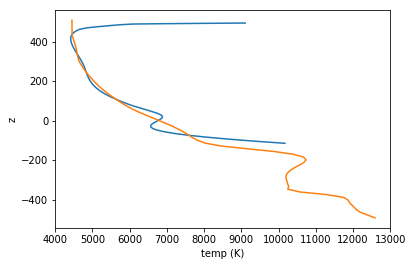

In [18]:
i = np.random.randint(252)
j = np.random.randint(252)
zoftau = interp1d(get_tau(i,j),sim_z,kind='linear')
plt.plot(t_sir[i,j,:],zoftau(tau_sir))
plt.plot(sim_temp[i,j,:],sim_z)
plt.ylabel('z')
plt.xlabel('temp (K)')

# Quantifying if different spectra produce different tau vs z profiles

(0, 4)

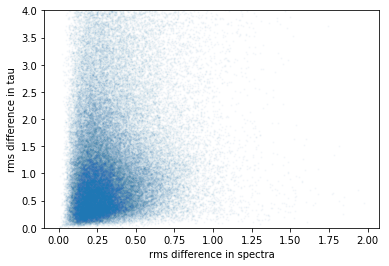

In [21]:

def rms_diff_spectra(i,j):
    spec1 = raw_spectra_list[i,:]
    spec2 = raw_spectra_list[j,:]
    return np.sqrt(np.mean(((spec1-spec2)/spec1)**2))

def rms_diff_tau(i,j):
    tau1 = raw_tau_list[i,:]
    tau2 = raw_tau_list[j,:]
    return np.sqrt(np.mean(((tau1-tau2)/tau1)**2))


raw_spectra_list = raw_spectra.reshape((252*252,257))
raw_tau_list = sim_tau.reshape((252*252,64))

spec_list_err = np.array([])
tau_list_err = np.array([])

for i in np.arange(100000):
    i = np.random.randint(252*252)
    j = np.random.randint(252*252)
    if i!=j:
        tau_elem = rms_diff_tau(i,j)
        if not np.isnan(tau_elem) and not np.isinf(tau_elem) and tau_elem<=4.0:
            spec_list_err = np.append(spec_list_err,rms_diff_spectra(i,j))
            tau_list_err = np.append(tau_list_err,rms_diff_tau(i,j))

plt.scatter(spec_list_err,tau_list_err,alpha=0.03,s=1.0)
plt.xlabel('rms difference in spectra')
plt.ylabel('rms difference in tau')
xrange = np.linspace(0,1, num=101)
#plt.plot(xrange,reg.coef_ * xrange + reg.intercept_)
plt.ylim(0,4)


# Keep it simple. Can the neural network learn the height at log tau = 0?

# To see if this is possible and avoid intrerpolating the cube, let's look at the index = 28. This corresponds to a height of 7.7km.

In [28]:
sim_z[28]

7.731582641601562

In [51]:
tau_train = sim_tau[:100,:100,28].reshape((10000,1))

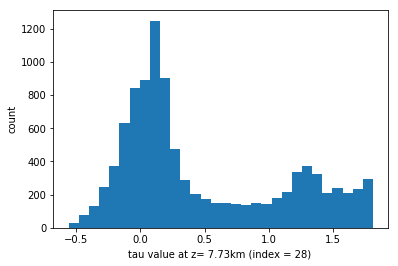

In [52]:
plt.hist(tau_train.flatten(),bins=30)
plt.xlabel('tau value at z= 7.73km (index = 28) ')
plt.ylabel('count')
plt.show()

In [70]:
n_batch = 128
tau_pts = 1

model = Sequential()

model.add(Dense(n_batch, activation='relu')) # input dim is number of spectra...
model.add(Dense(int(n_batch/2), activation='relu')) # input dim is number of spectra...
model.add(Dense(int(n_batch/4), activation='relu')) # input dim is number of spectra...
model.add(Dense(int(n_batch/6), activation='relu')) # input dim is number of spectra...
model.add(Dense(int(n_batch/8), activation='relu')) # input dim is number of spectra...

model.add(Dense(tau_pts, activation='linear')) # final layer wich has number outputs = tau points i'm inferring

model.compile(optimizer='adam',
              loss='mse')

spectra_train = raw_spectra[:100,:100,:].reshape((10000,257))
tau_train = sim_tau[:100,:100,28].reshape((10000,1))

model.fit(spectra_train, tau_train, epochs=10, batch_size=n_batch)
print("finished training")
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
print("saved model")


Epoch 1/10
10000/10000 [==============================] - 0s 10us/step - loss: 0.4669
Epoch 2/10
10000/10000 [==============================] - 0s 10us/step - loss: 0.3922
Epoch 3/10
10000/10000 [==============================] - 0s 12us/step - loss: 0.3924
Epoch 4/10
10000/10000 [==============================] - 0s 13us/step - loss: 0.3924
Epoch 5/10
10000/10000 [==============================] - 0s 12us/step - loss: 0.3929
Epoch 6/10
10000/10000 [==============================] - 0s 12us/step - loss: 0.3924
Epoch 7/10
10000/10000 [==============================] - 0s 15us/step - loss: 0.3924
Epoch 8/10
10000/10000 [==============================] - 0s 24us/step - loss: 0.3926
Epoch 9/10
10000/10000 [==============================] - 0s 25us/step - loss: 0.3925
Epoch 10/10
10000/10000 [==============================] - 0s 20us/step - loss: 0.3924
finished training
saved model
